In [1]:
!git clone https://github.com/tvaditya/tracksintro

fatal: destination path 'tracksintro' already exists and is not an empty directory.


In [2]:
!ls tracksintro


driving_log.csv  IMG  README.md


In [3]:
!pip3 install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [5]:
datadir = 'tracksintro'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
# display maximum column width , avoida the ellipsis
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_148.jpg   
1  C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_248.jpg   
2  C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_349.jpg   
3  C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_463.jpg   
4  C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_563.jpg   

                                                                   left  \
0   C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_148.jpg   
1   C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_248.jpg   
2   C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_349.jpg   
3   C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_463.jpg   
4   C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_563.jpg   

                                                                   right  \
0   C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_148.jpg   
1   C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_248.jpg   
2   C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_349.jpg   
3   C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_463.jpg   
4   C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_563.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000078  
1  0.0       0.0       0.0      0.000079  
2  0.0       0.0       0.0      0.000079  
3  0.0       0.0       0.0      0.000078  
4  0.0       0.0       0.0      0.000080

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)


In [7]:
data.head()

center                              left  \
0  center_2019_01_27_21_41_00_148.jpg  left_2019_01_27_21_41_00_148.jpg   
1  center_2019_01_27_21_41_00_248.jpg  left_2019_01_27_21_41_00_248.jpg   
2  center_2019_01_27_21_41_00_349.jpg  left_2019_01_27_21_41_00_349.jpg   
3  center_2019_01_27_21_41_00_463.jpg  left_2019_01_27_21_41_00_463.jpg   
4  center_2019_01_27_21_41_00_563.jpg  left_2019_01_27_21_41_00_563.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2019_01_27_21_41_00_148.jpg  0.0       0.0       0.0      0.000078  
1  right_2019_01_27_21_41_00_248.jpg  0.0       0.0       0.0      0.000079  
2  right_2019_01_27_21_41_00_349.jpg  0.0       0.0       0.0      0.000079  
3  right_2019_01_27_21_41_00_463.jpg  0.0       0.0       0.0      0.000078  
4  right_2019_01_27_21_41_00_563.jpg  0.0       0.0       0.0      0.000080

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


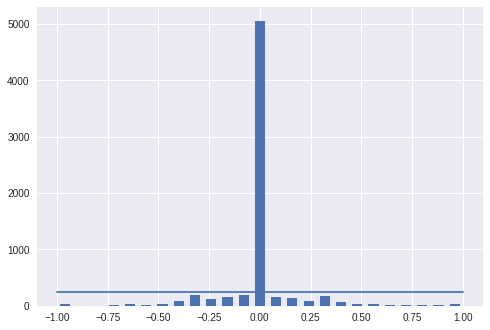

In [8]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6702
removed: 4798
remaining: 1904


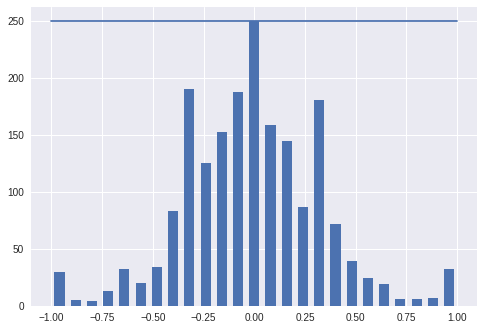

In [9]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [10]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # centered image append
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_01_27_21_41_02_087.jpg
left        left_2019_01_27_21_41_02_087.jpg  
right       right_2019_01_27_21_41_02_087.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.8386e-05                        
Name: 18, dtype: object


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=42)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 4569
Valid Samples: 1143


Text(0.5, 1.0, 'Validation set')

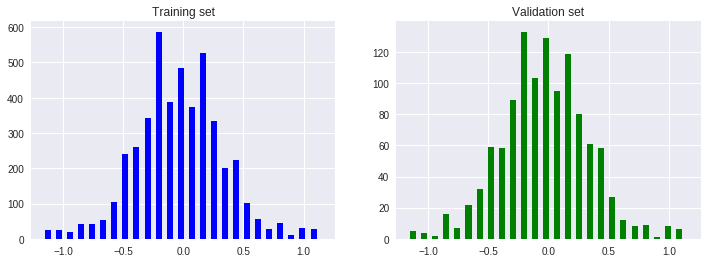

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='green')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image


Text(0.5, 1.0, 'Zoomed Image')

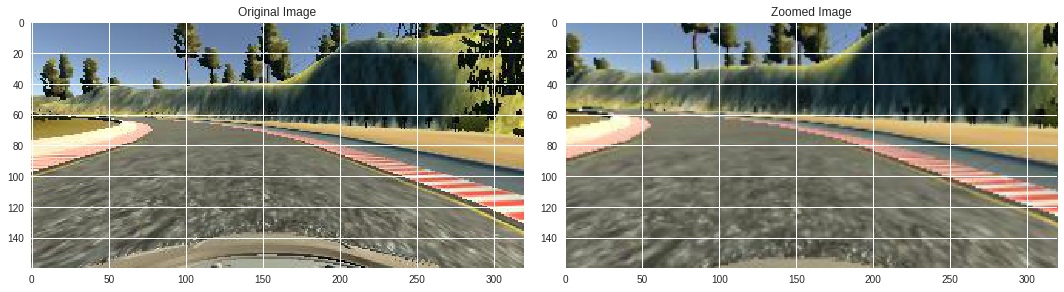

In [14]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

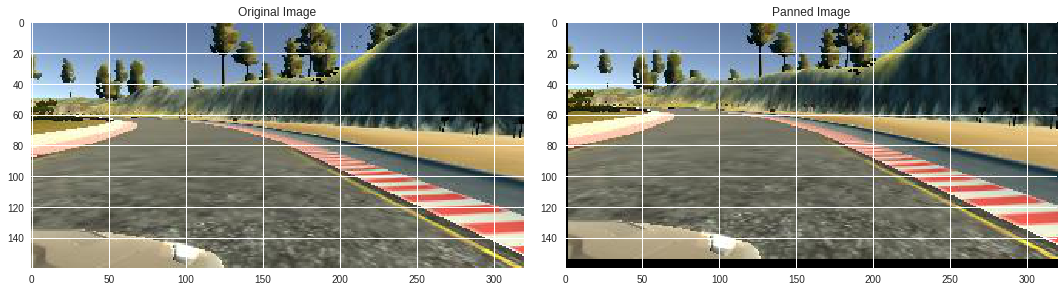

In [16]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

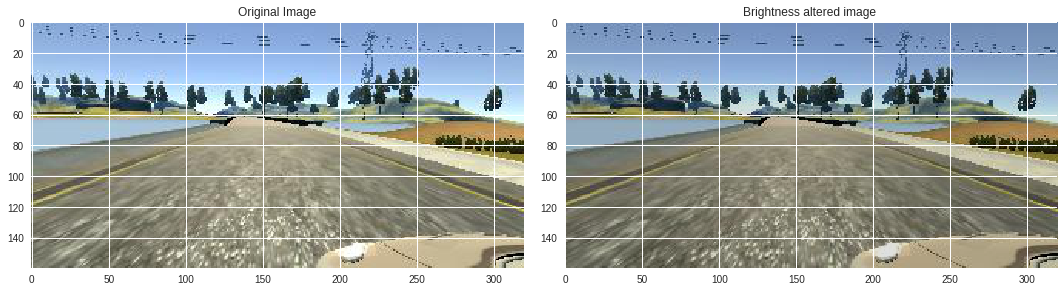

In [18]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.5053507')

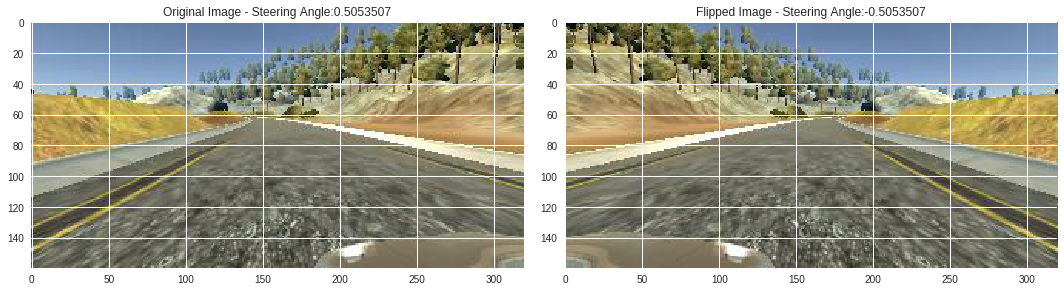

In [20]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

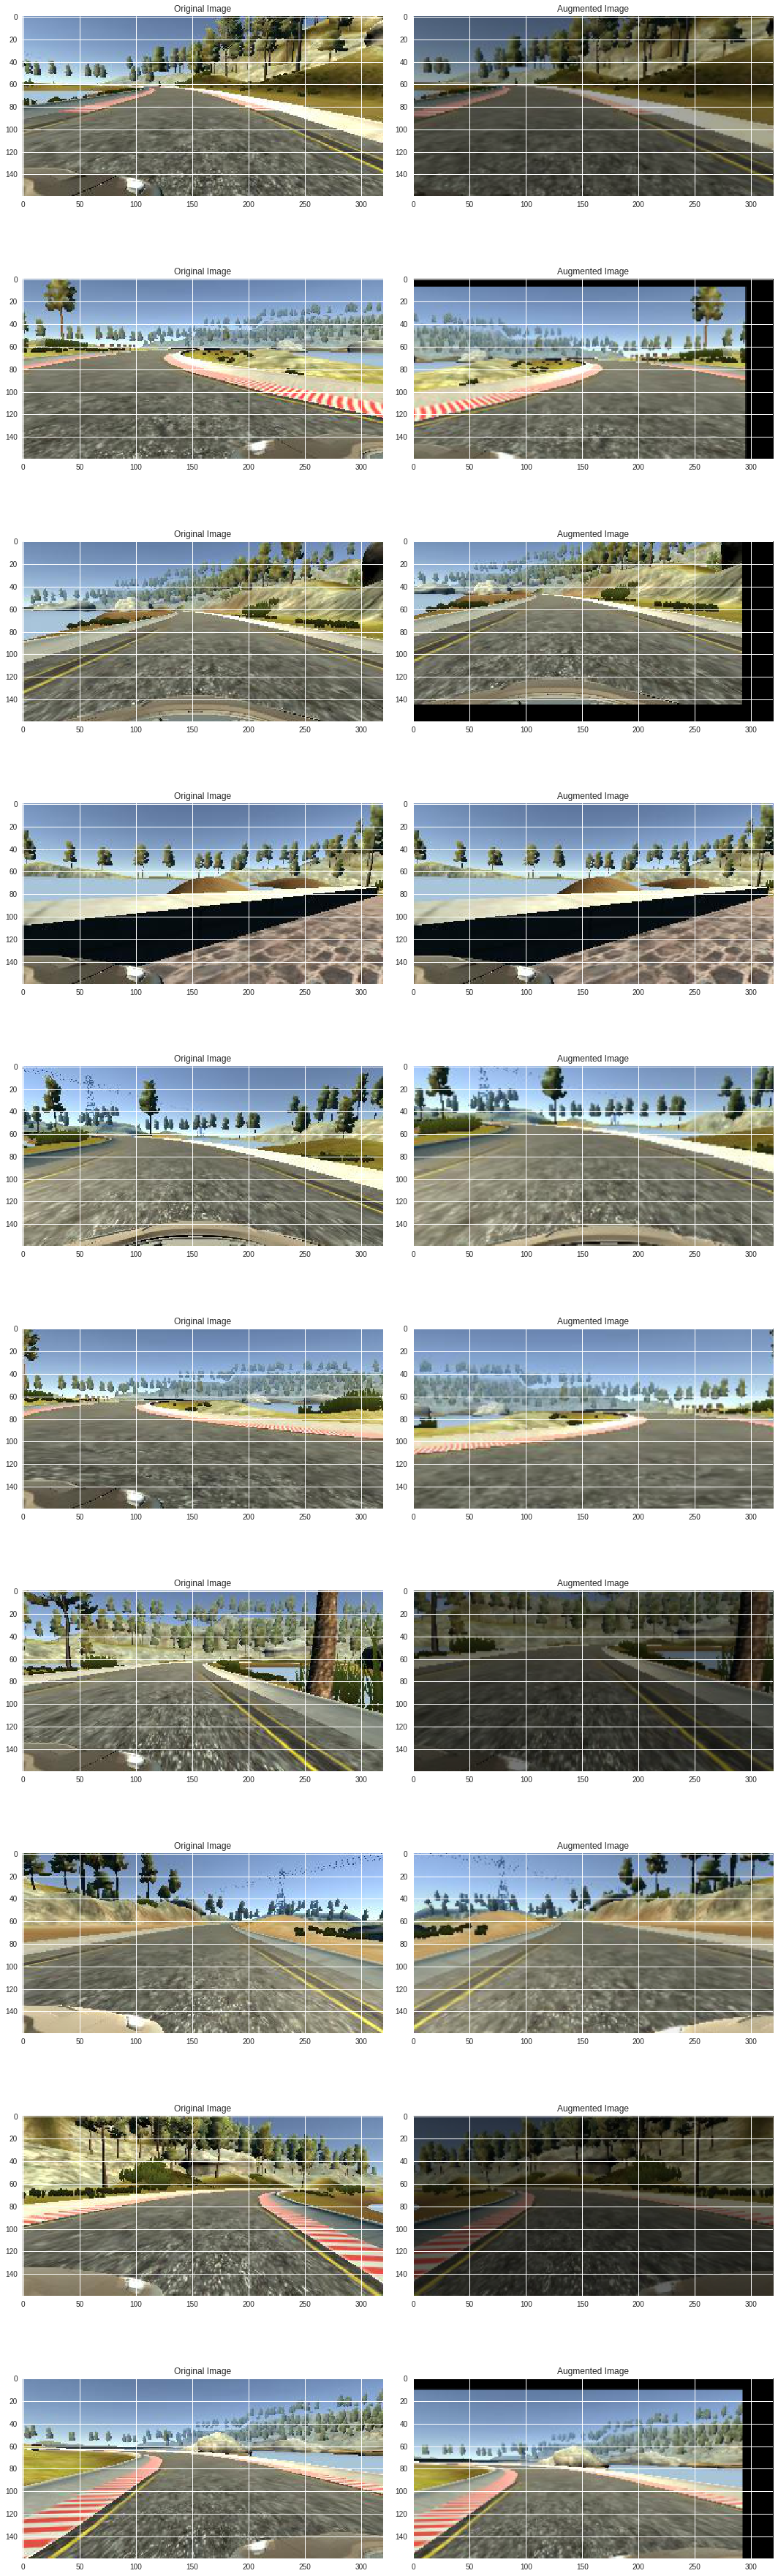

In [22]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [0]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

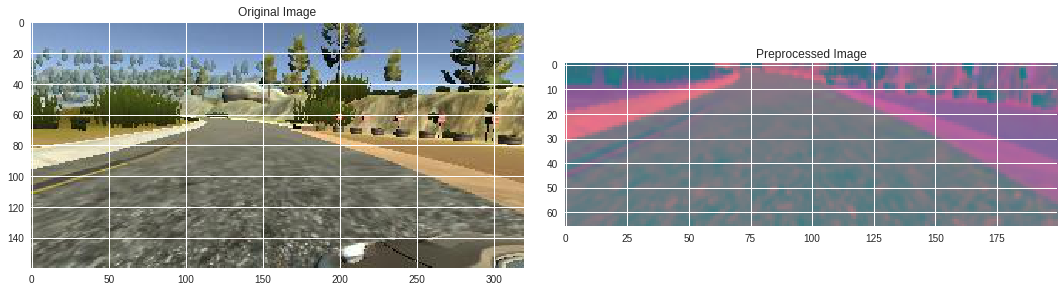

In [24]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  
    # each time yield is executed the func generates a new value
    # when the generator is called again the values inside do not reinitialize but instead take on their older values.

Text(0.5, 1.0, 'Validation Image')

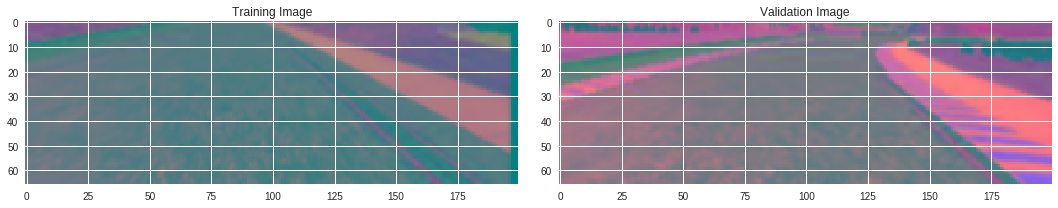

In [26]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
# def img_preprocess(img):
#   img = mpimg.imread(img)
#   img = img[60:135,:,:]
#   return img

In [0]:
# fig, axs = plt.subplots(1, 2, figsize=(15,10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Orginal Image')
# axs[1].imshow(preprocessed_image)
# axs[1].set_title('Preprocessed Image')

In [0]:
# image = image_paths[99]
# original_image = mpimg.imread(image)
# preprocessed_image = img_preprocess(image)

In [0]:
# fig, axs = plt.subplots(1, 2, figsize=(15,10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Orginal Image')
# axs[1].imshow(preprocessed_image)
# axs[1].set_title('Preprocessed Image')

In [0]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])
# plt.axis('off')
# print(X_train.shape)

In [0]:


def nvidia_model():
  model = Sequential()
  # subsample refers to the stride length of our kernel, as we have a bigger image we can use a bigger stride
  # no padding needed as there is nothing meaningful in images borders
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  #model.add(Dropout(0.5))
  # model dimension have reduced well no need for subsample   
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#  model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(200, activation = 'elu'))
 # model.add(Dropout(0.5))
  
  model.add(Dense(100, activation = 'elu'))
#  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
 # model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [34]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  del sys.path

In [0]:
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle = 1)

In [36]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 144s 480ms/step - loss: 0.1260 - val_loss: 0.0850
Epoch 2/10
300/300 [==============================] - 143s 476ms/step - loss: 0.1095 - val_loss: 0.0749
Epoch 3/10
300/300 [==============================] - 142s 473ms/step - loss: 0.0965 - val_loss: 0.0698
Epoch 4/10
300/300 [==============================] - 143s 478ms/step - loss: 0.0901 - val_loss: 0.0673
Epoch 5/10
300/300 [==============================] - 140s 468ms/step - loss: 0.0861 - val_loss: 0.0610
Epoch 6/10
300/300 [==============================] - 143s 476ms/step - loss: 0.0852 - val_loss: 0.0614
Epoch 7/10
300/300 [==============================] - 140s 468ms/step - loss: 0.0809 - val_loss: 0.0557
Epoch 8/10
300/300 [==============================] - 140s 466ms/step - loss: 0.0806 - val_loss: 0.0577
Epoch 9/10
300/300 [==============================] - 135s 451ms/step - loss: 0.0778 - val_loss: 0.0526
Epoch 10/10
300/300 [==============================] - 131s 436m

Text(0.5, 0, 'Epoch')

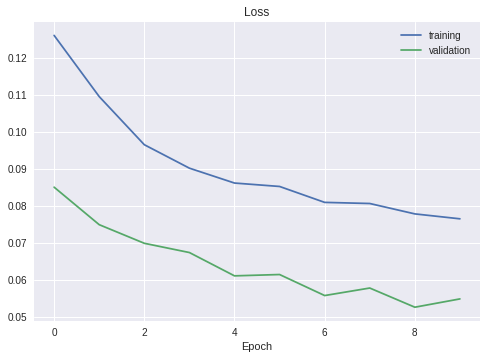

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model1.h5')

In [0]:
from google.colab import files
files.download('model1.h5')